[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/zora-no/iannwtf/blob/main/hw-week09/hw_week09_group27.ipynb)
# Homework 09 — IANNwTF
## Group 27
Deadline: Jan 16, 2021 23:59

<https://forms.gle/n6ERdhYx3uBPzuGn9>


In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import tqdm
import datetime
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.size'] = 15

# The Quick, Draw! Dataset

In [2]:
import os
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [3]:
import urllib
categories = [line.rstrip(b'\n') for line in urllib.request.urlopen('https://raw.githubusercontent.com/googlecreativelab/quickdraw-dataset/master/categories.txt')]
print(categories[:10])
category = 'candle'

[b'aircraft carrier', b'airplane', b'alarm clock', b'ambulance', b'angel', b'animal migration', b'ant', b'anvil', b'apple', b'arm']


In [4]:
# Creates a folder to download the original drawings into.
# We chose to use the numpy format : 1x784 pixel vectors, with values going from 0 (white) to 255 (black).
# We reshape them later to 28x28 grids and normalize the pixel intensity to [-1, 1]

if not os.path.isdir('npy_files'):
    os.mkdir('npy_files')
    
url = f'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/{category}.npy'  
urllib.request.urlretrieve(url, f'npy_files/{category}.npy')

candles = np.load(f'npy_files/{category}.npy')
candles = candles[:20000]
print(f'{len(candles)} images available')

20000 images available


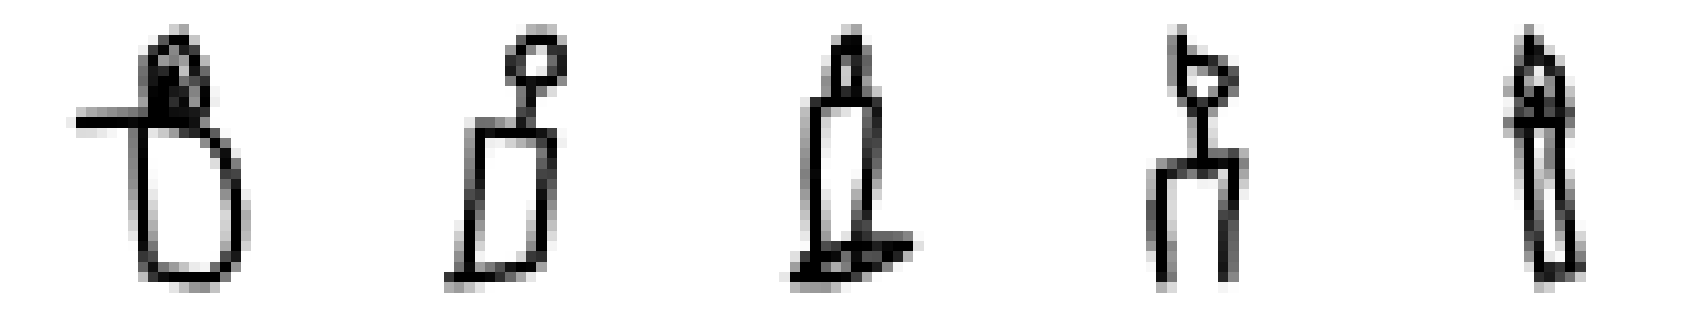

In [5]:
# show example images
npics = 5
fig, ax = plt.subplots(nrows=1, ncols=npics, figsize=(15,3))
ax = ax.flatten()
for i in range(5):
    ax[i].imshow(np.reshape(candles[i], (28, 28)), cmap='gray_r', vmin=0, vmax=255)
    ax[i].axis("off")

# Preprocessing

In [6]:
def prepare_data(image_array):
    # create dataset from array
    ds = tf.data.Dataset.from_tensor_slices(image_array)
    # cast tensors to float32
    ds = ds.map(lambda img: tf.cast(img, tf.float32))
    # reshape the pixel arrays to images
    ds = ds.map(lambda img: tf.reshape(img, (28,28,1)))
    # normalize (bring values to a range from -1 to 1)
    ds = ds.map(lambda img: ((img/128.)-1.))
    # shuffle, batch, prefetch
    ds = ds.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
    return ds

In [7]:
images = prepare_data(candles)
for i in images.take(1):
    print(i.shape)

(32, 28, 28, 1)


# Model: GAN
## The discriminator network

In [8]:
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.layers_list = [
            # first convolution
            tf.keras.layers.Conv2D(64,
                                   (4,4),
                                   strides=2,
                                   padding='same',
                                   input_shape=(28, 28, 1)),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            # second convolution
            tf.keras.layers.Conv2D(128,
                                   kernel_size=4,
                                   strides=2,
                                   padding="same"),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            # third convolution
            tf.keras.layers.Conv2D(128,
                                   kernel_size=4,
                                   strides=2,
                                   padding="same"),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            # flatten
            tf.keras.layers.Flatten(),
            # single dropout layer
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(1, activation='sigmoid'),
        ]
  
    def call(self, x, training=True):

        for layer in self.layers_list:
            try:
                x = layer(x, training)
            except:
                x = layer(x)
       
        return x

## The generator network
Partly following <https://www.tensorflow.org/tutorials/generative/dcgan#the_generator>

In [9]:
class Generator(tf.keras.Model):
    
    """
    The generator uses upsampling layers to produce an image
    of size 28x28x1 from random noise. Uses leaky ReLU as the activation
    function for all layers except the output layer.
    """
    
    def __init__(self):
        super(Generator, self).__init__()
        
        self.layers_list = [
            tf.keras.layers.Dense(7*7*128,
                                  input_shape=(100,), # the latent space will be made of 100-dimensional vectors
                                  activation=None),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            tf.keras.layers.Reshape((7, 7, 128)),
            
            tf.keras.layers.Conv2DTranspose(filters=128,
                                            kernel_size=4,
                                            strides=2,
                                            padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            
            tf.keras.layers.Conv2DTranspose(64,
                                            kernel_size=4,
                                            strides=2,
                                            padding="same"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            tf.keras.layers.Conv2DTranspose(32,
                                            kernel_size=4,
                                            strides=2,
                                            padding="same"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            tf.keras.layers.Conv2D(1,
                                   kernel_size=4,
                                   strides=2,
                                   padding="same",
                                   activation="tanh"),  
        ]

    def call(self, x, training=True):

        for layer in self.layers_list:
            try:
                x = layer(x, training)
            except:
                x = layer(x)
       
        return x

Use the (untrained) generator to create an image.

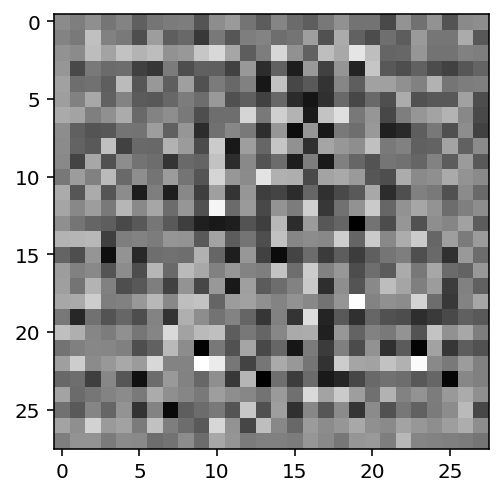

In [10]:
test_generator = Generator()

noise = tf.random.normal([1, 100])
generated_image = test_generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray');

In [11]:
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss") # discriminator loss metric
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss") # generator loss metric
        self.d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
        self.g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
        self.loss_fn = tf.keras.losses.BinaryCrossentropy()
    
    
    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_states()
    
    
    @tf.function
    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        generated_images = self.generator(random_latent_vectors)
        combined_images = tf.concat([generated_images, real_images], axis=0)
        labels = tf.concat([tf.ones((batch_size, 1)),
                            tf.zeros((batch_size, 1))],
                           axis=0) # labels are ones for fake images and zeros for real ones
        labels += 0.05 * tf.random.uniform(tf.shape(labels)) # add random noise to the labels
        
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions) # discriminator loss
        grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_variables))
        
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        misleading_labels = tf.zeros((batch_size, 1))
        
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions) # generator loss
        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result()}

# Training

In [12]:
discriminator = Discriminator()
generator = Generator()
epochs = 20
gan = GAN(discriminator=discriminator, generator=generator,
          latent_dim=100)

In [13]:
from tqdm import notebook

%load_ext tensorboard
%tensorboard --logdir /content/logs
summary_writer = tf.summary.create_file_writer("/content/logs")

for epoch in range(epochs):
    
    print(f"Epoch {epoch}:")
    
    for data in notebook.tqdm(images, position=0, leave=True):
        metrics = gan.train_step(data)
    
    latent_vectors = tf.random.normal(shape=(3, 100))
    generated_images = gan.generator(latent_vectors, training = False)
    
    # print the metrics
    print([f"{key}: {value}" for (key, value) in zip(list(metrics.keys()), list(metrics.values()))])
    
    # saving the metrics to a log file
    with summary_writer.as_default():
        for metric in gan.metrics:
            tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)
        tf.summary.image(name="generated_images", data = generated_images, step=epoch, max_outputs=3)
    
    # reset all metrics
    gan.reset_metrics()
    print("\n")


Reusing TensorBoard on port 6006 (pid 258), started 1:17:01 ago. (Use '!kill 258' to kill it.)

<IPython.core.display.Javascript object>

Epoch 0:


  0%|          | 0/625 [00:00<?, ?it/s]

['d_loss: 0.4713086783885956', 'g_loss: 1.7560172080993652']


Epoch 1:


  0%|          | 0/625 [00:00<?, ?it/s]

['d_loss: 0.313035786151886', 'g_loss: 2.558018445968628']


Epoch 2:


  0%|          | 0/625 [00:00<?, ?it/s]

['d_loss: 0.24077899754047394', 'g_loss: 3.2111566066741943']


Epoch 3:


  0%|          | 0/625 [00:00<?, ?it/s]

['d_loss: 0.3931628167629242', 'g_loss: 1.9770880937576294']


Epoch 4:


  0%|          | 0/625 [00:00<?, ?it/s]

['d_loss: 0.48215019702911377', 'g_loss: 1.4219659566879272']


Epoch 5:


  0%|          | 0/625 [00:00<?, ?it/s]

['d_loss: 0.3792114555835724', 'g_loss: 1.8063037395477295']


Epoch 6:


  0%|          | 0/625 [00:00<?, ?it/s]

['d_loss: 0.34082114696502686', 'g_loss: 1.9725369215011597']


Epoch 7:


  0%|          | 0/625 [00:00<?, ?it/s]

['d_loss: 0.40638959407806396', 'g_loss: 1.6805431842803955']


Epoch 8:


  0%|          | 0/625 [00:00<?, ?it/s]

['d_loss: 0.49928417801856995', 'g_loss: 1.3726950883865356']


Epoch 9:


  0%|          | 0/625 [00:00<?, ?it/s]

['d_loss: 0.5221759080886841', 'g_loss: 1.233241081237793']


Epoch 10:


  0%|          | 0/625 [00:00<?, ?it/s]

['d_loss: 0.533473789691925', 'g_loss: 1.2265254259109497']


Epoch 11:


  0%|          | 0/625 [00:00<?, ?it/s]

['d_loss: 0.5396276116371155', 'g_loss: 1.175235629081726']


Epoch 12:


  0%|          | 0/625 [00:00<?, ?it/s]

['d_loss: 0.5429016351699829', 'g_loss: 1.1813554763793945']


Epoch 13:


  0%|          | 0/625 [00:00<?, ?it/s]

['d_loss: 0.5451030135154724', 'g_loss: 1.1584314107894897']


Epoch 14:


  0%|          | 0/625 [00:00<?, ?it/s]

['d_loss: 0.5481781363487244', 'g_loss: 1.1584445238113403']


Epoch 15:


  0%|          | 0/625 [00:00<?, ?it/s]

['d_loss: 0.5548426508903503', 'g_loss: 1.1371417045593262']


Epoch 16:


  0%|          | 0/625 [00:00<?, ?it/s]

['d_loss: 0.5572354793548584', 'g_loss: 1.11350679397583']


Epoch 17:


  0%|          | 0/625 [00:00<?, ?it/s]

['d_loss: 0.5640573501586914', 'g_loss: 1.116863489151001']


Epoch 18:


  0%|          | 0/625 [00:00<?, ?it/s]

['d_loss: 0.5589967966079712', 'g_loss: 1.1064684391021729']


Epoch 19:


  0%|          | 0/625 [00:00<?, ?it/s]

['d_loss: 0.5648475885391235', 'g_loss: 1.0975079536437988']




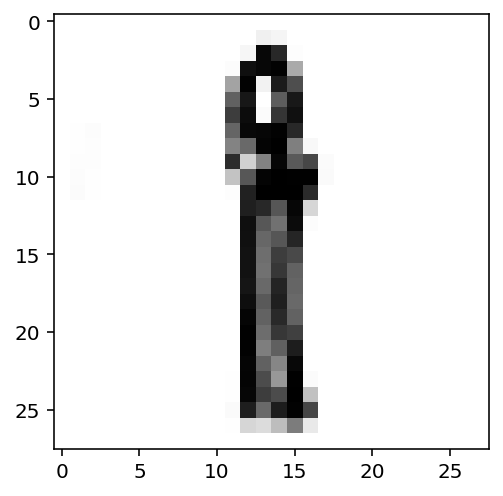

In [21]:
noise = tf.random.normal([1, 100])
generated_image = gan.generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray_r');

In [ ]:
# Adapted from https://www.tensorflow.org/tutorials/generative/dcgan
import random

for i in range(10):
  fig = plt.figure(figsize=(6, 6))
  for j in range(16):
    plt.subplot(4, 4, j+1)
    noise = tf.random.normal([1, 100])
    generated_images = gan.generator(noise, training=False)
    colors = random.choice(["Blues", "Purples", "Reds",
                            "Greens", "Purples_r",
                            "Reds_r", "PuBuGn", "PuBuGn_r",
                            "YlOrRd"])
    plt.imshow(generated_images[0, :, :, 0] * 127.5 + 127.5, cmap=colors)
    plt.axis('off')
  plt.savefig(f'candle{i}.png')


anim_file = 'candles.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('candle*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


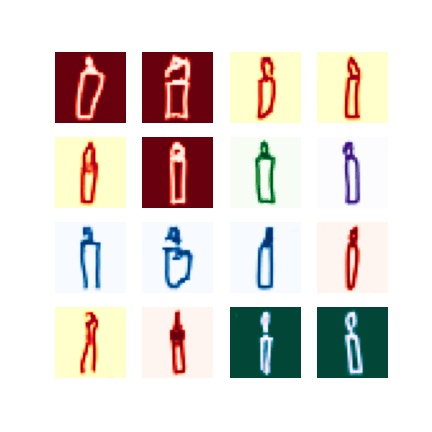

In [18]:
!pip install -q git+https://github.com/tensorflow/docs
import tensorflow_docs.vis.embed as embed
embed.embed_file('candles.gif')